In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader 
from torch.autograd import Variable
from torch.backends import cudnn


import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
import numpy as np


# Augmenting library 

import torchvision
import torchvision.transforms.functional as TF
import albumentations as A
import torchvision.transforms as T

# Control Randomness
import random
random_seed = 7
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

import warnings
warnings.filterwarnings("ignore")
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
print(torch.cuda.device_count())


# logging
import datetime
from tensorboardX import SummaryWriter
from tqdm import tqdm
import time 

/home/sklab2/anaconda3/envs/vessel2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1


In [2]:
import joint_transforms
from config import cod_training_root
from config import backbone_path
from datasets import ImageFolder
from misc import AvgMeter, check_mkdir
from PFNet import PFNet
from helper import FocalLoss, CosineAnnealingWarmupRestarts
import loss

# Config

In [3]:
ckpt_path = './ckpt'
exp_name = 'PFNet'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args = {
    'epoch_num': 300,
    'train_batch_size': 32,
    'last_epoch': 0,
    'lr': 1e-4, 
    'lr_decay': 0.9,
    'weight_decay': 5e-4,
    'momentum': 0.9,
    'snapshot': '',
    'scale': 416, 
    'save_point': [],
    'poly_train': False,
    'optimizer': 'Adam',
    'amp' : False
}

In [4]:
from helper import BinaryFocalLoss, sigmoid_focal_loss
# loss function
structure_loss = loss.structure_loss().to(device)
bce_loss = nn.BCEWithLogitsLoss().to(device)
iou_loss = loss.IOU().to(device)
focal_loss = BinaryFocalLoss(alpha=3, gamma=2, ignore_index=None, reduction='mean')

def bce_iou_loss(pred, target):
    bce_out = bce_loss(pred, target)
    iou_out = iou_loss(pred, target)
    loss = bce_out + iou_out
    return loss

def focal_iou_loss(pred, target):
    focal_out = sigmoid_focal_loss(pred, target, alpha=0.25)
    iou_out = iou_loss(pred, target)
    loss = focal_out + iou_out
    return loss

# Net

In [5]:
net_r = PFNet(backbone_path)
net_y = PFNet(backbone_path)
optimizer_r = torch.optim.Adam(net_r.parameters(), lr=args['lr'])
optimizer_y = torch.optim.Adam(net_y.parameters(), lr=args['lr'])
scheduler_r = CosineAnnealingWarmupRestarts(optimizer_r, first_cycle_steps=50, cycle_mult=1.0, max_lr=1e-3, min_lr=1e-5, warmup_steps=5, gamma=0.8)
scheduler_y = CosineAnnealingWarmupRestarts(optimizer_y, first_cycle_steps=50, cycle_mult=1.0, max_lr=1e-3, min_lr=1e-5, warmup_steps=5, gamma=0.8)

From ./backbone/resnet/resnet50-19c8e357.pth Load resnet50 Weights Succeed!
From ./backbone/resnet/resnet50-19c8e357.pth Load resnet50 Weights Succeed!


## making data index list

In [6]:
mask_files = os.walk("/home/sklab2/workspace/datashared/SS-OCT/vessel_segmentation/masked")
mask_idx = []
for (root, dirs, files) in mask_files:
    if len(files) > 0 :
        mask_idx.append(files)

mask_idxs = [element for array in mask_idx for element in array]
len(mask_idxs)

1691

In [7]:
# 1~ 11 / 12, 13, 14  , 40, 41, 43, 44, 46, 49,  50, 53, 54, 55 
train_indexs = []
test_indexs = []
for idx, data in enumerate(mask_idxs):
    tmp = mask_idxs[idx].split('_')
    if len(tmp) < 3:
        if int(tmp[0]) < 45:
            train_indexs.append([ tmp[0], tmp[1].split('.')[0]])
        else:
            test_indexs.append([tmp[0], tmp[1].split('.')[0]])

In [8]:
len(train_indexs) , len(test_indexs)

(1319, 355)

# Dataloader

In [9]:
import albumentations.augmentations.functional as AF

PATH = '/home/sklab2/workspace/datashared/SS-OCT/vessel_segmentation/'
class VesselDataset(Dataset):
    def __init__(self, index, transforms):
        self.index = index
        self.transforms = transforms
        
    def __len__(self):
        return len(self.index)
        
    def __getitem__(self, idx):
        s_1 = self.index[idx][0]
        s_2 = self.index[idx][1]

        # '1_L_0.jpg', 
        # image = Image.open(PATH+'origin/' + s_1+'_L_'+s_2+'.jpg').convert("L").resize((416, 416),Image.Resampling.BILINEAR)
        image = Image.open(PATH+'origin/' + s_1+'_L_'+s_2+'.jpg').resize((416, 416),Image.Resampling.BILINEAR)
        #'10_L_112_L.png', 
        mask = Image.open(PATH+'masked/' +  s_1+'_'+s_2+'.png').resize((416, 416),Image.Resampling.NEAREST)
        
        image = np.array(image) #RGB
        mask = np.array(mask, dtype=np.uint8)   # HWC
        # mask_o = mask / 255        # CHW
        mask_o = mask.transpose(2, 0, 1)
        lower_red = np.array([-10, 100, 100]) 
        upper_red = np.array([10, 255, 255])

        lower_yellow = np.array([22, 93, 0]) 
        upper_yellow = np.array([45, 255, 255])

        # lower_yellow = np.array([55, 60, 200]) 
        # upper_yellow = np.array([60, 255, 255]) 

        mask_hsv = cv2.cvtColor(mask, cv2.COLOR_RGB2HSV)

        mask_r = cv2.inRange(mask_hsv, lower_red, upper_red)
        mask_y = cv2.inRange(mask_hsv, lower_yellow, upper_yellow)
        # mask_y = 255 - mask_y # 색반전
        mask_r = mask_r/255
        mask_y = mask_y/255

        mask_r = np.clip(mask_r, 0 ,1)
        mask_y = np.clip(mask_y, 0, 1)

        # mask_r = np.expand_dims(mask_r,axis=0)
        # mask_y = np.expand_dims(mask_y,axis=0)

        # mask = np.concatenate([mask_r, mask_y], axis=0)
        masks = [mask_r, mask_y]
        # print(mask.shape)
    
        # aft_mask = cv2.resize(aft_mask, (416, 416), interpolation=cv2.INTER_NEAREST)
        # for num in range(3): #### 3번 이터레이션이 왜들어갔지?
        if self.transforms:
            transformed = self.transforms(image=image, masks=masks)
            image, masks = transformed['image'], transformed['masks']

        # mask = np.concatenate([masks[0], masks[1]], axis=-3)
        # mask = torch.from_numpy(mask).type(torch.LongTensor)
        
        # urls.append(s_1+'_'+s_2)
        # assert sum(masks[0]==0).sum() + sum(masks[0]==1).sum() == 416*416   # mask가 0 또는 1이 아닐경우 스탑
                    
        return image, masks, mask_o

In [10]:
import albumentations.pytorch as AP

train_transforms = A.Compose([
    A.RandomRotate90(p=0.25),
    A.RandomResizedCrop(416, 416, scale=(0.25, 1.0), ratio=(0.8, 1.2), interpolation=cv2.INTER_AREA, p=0.25),
    A.OneOf([
        A.OpticalDistortion(p=1, interpolation=cv2.INTER_AREA),
        A.GridDistortion(p=1, interpolation=cv2.INTER_AREA),
        A.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, interpolation=cv2.INTER_AREA)
        ], p = 0.5),  # 밝기 및 조도 변화
    # A.Normalize(mean=(126.71482973095203, 126.6879562017254, 126.85466873988524), std = (32.9434, 33.0122, 32.9186)),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.25),
    AP.ToTensorV2(transpose_mask=False),
    
])

test_transforms = A.Compose([
    AP.ToTensorV2(transpose_mask=False)
])

train_dataset = VesselDataset(index=train_indexs, transforms=train_transforms)
test_dataset = VesselDataset(index=test_indexs, transforms=test_transforms)
 
#train_dataset, _, test_dataset = torch.utils.data.random_split(dataset, [train, 0, test])

train_loader = DataLoader(dataset=train_dataset, batch_size=args['train_batch_size'], shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

# image, [mask_r, mask_y, mask_o] =next(iter(train_loader))
image,[mask_r, mask_y], mask_o = next(iter(train_loader))
print(image.shape, mask_r.shape, mask_y.shape, mask_o.shape)

torch.Size([32, 3, 416, 416]) torch.Size([32, 416, 416]) torch.Size([32, 416, 416]) torch.Size([32, 3, 416, 416])


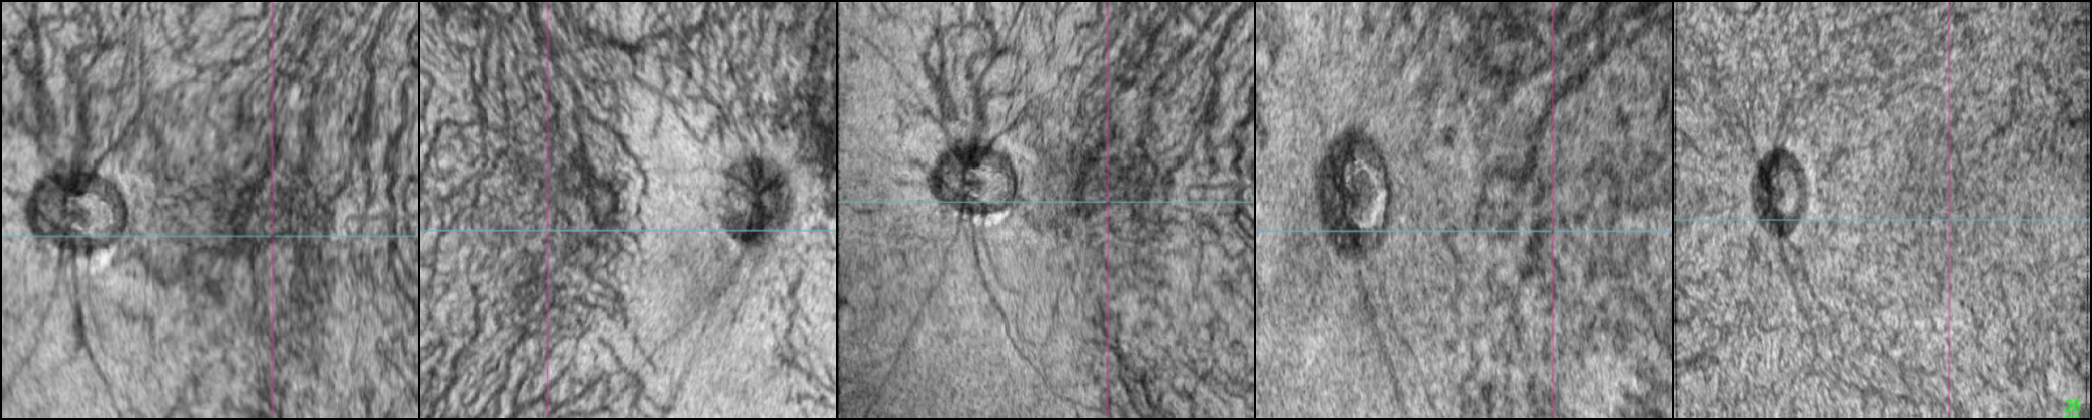

In [11]:
TF.to_pil_image(torchvision.utils.make_grid(image[:5]))

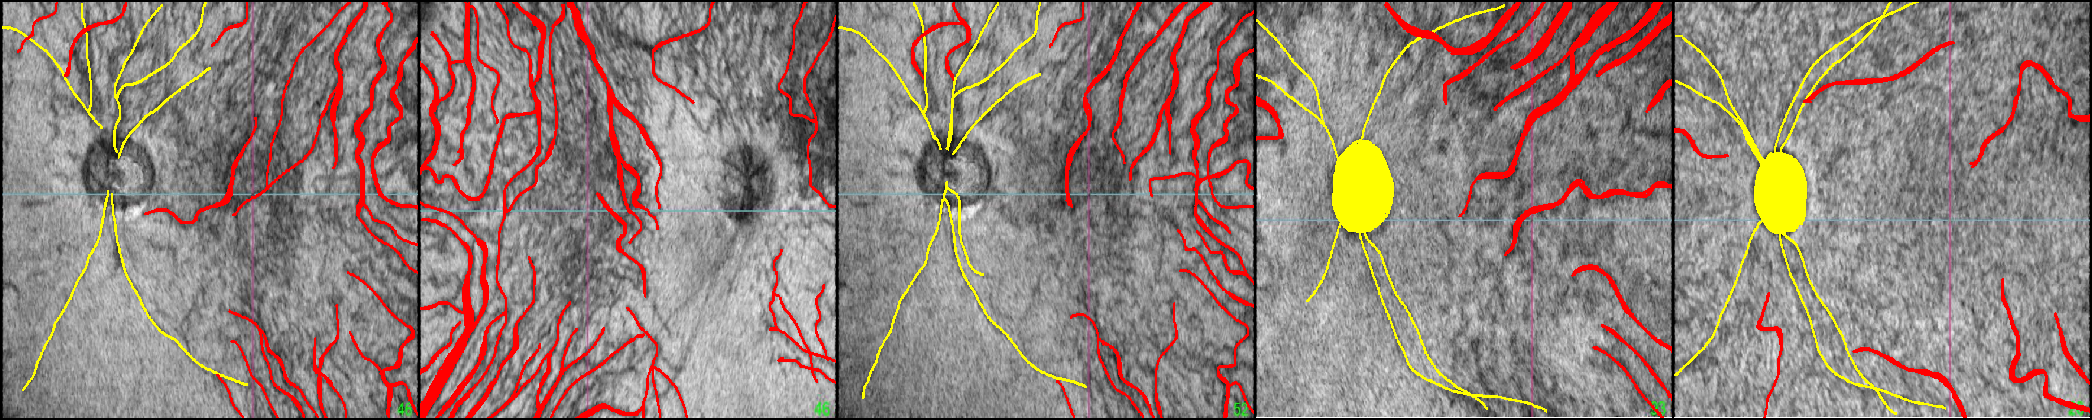

In [12]:
TF.to_pil_image(torchvision.utils.make_grid(mask_o[:5]))

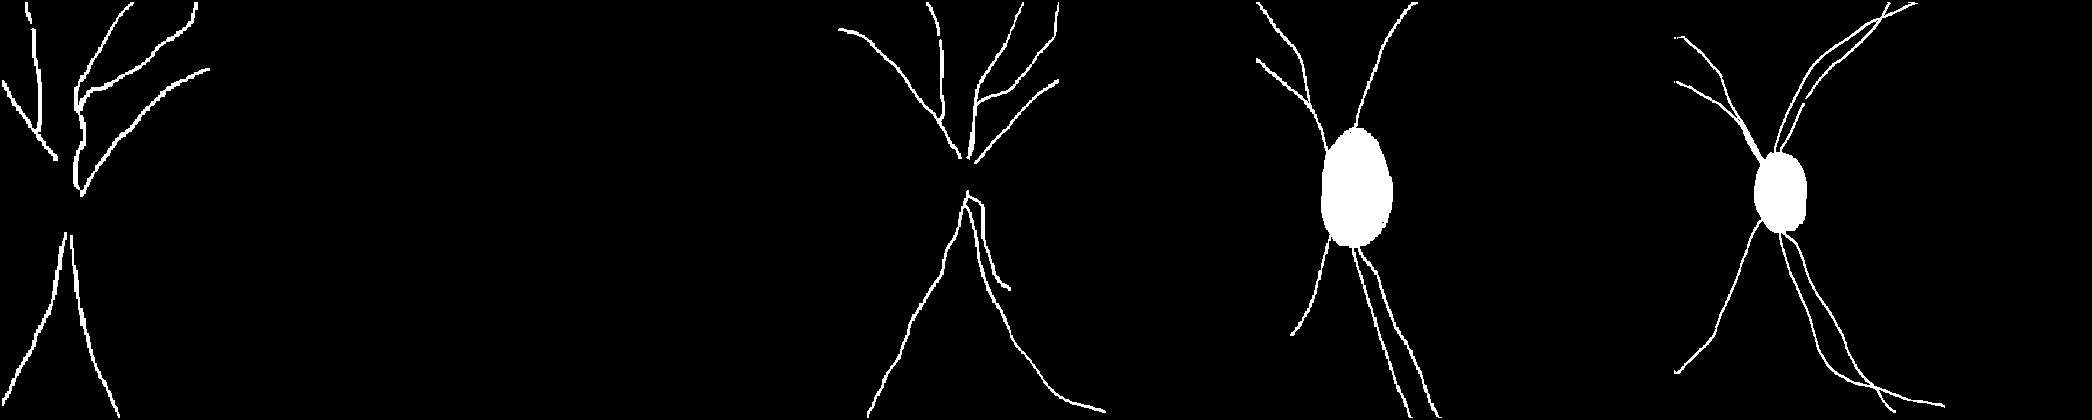

In [14]:
TF.to_pil_image(torchvision.utils.make_grid(mask_y[:5].unsqueeze(-3).expand(5, 3, 416, 416).type(torch.float)))

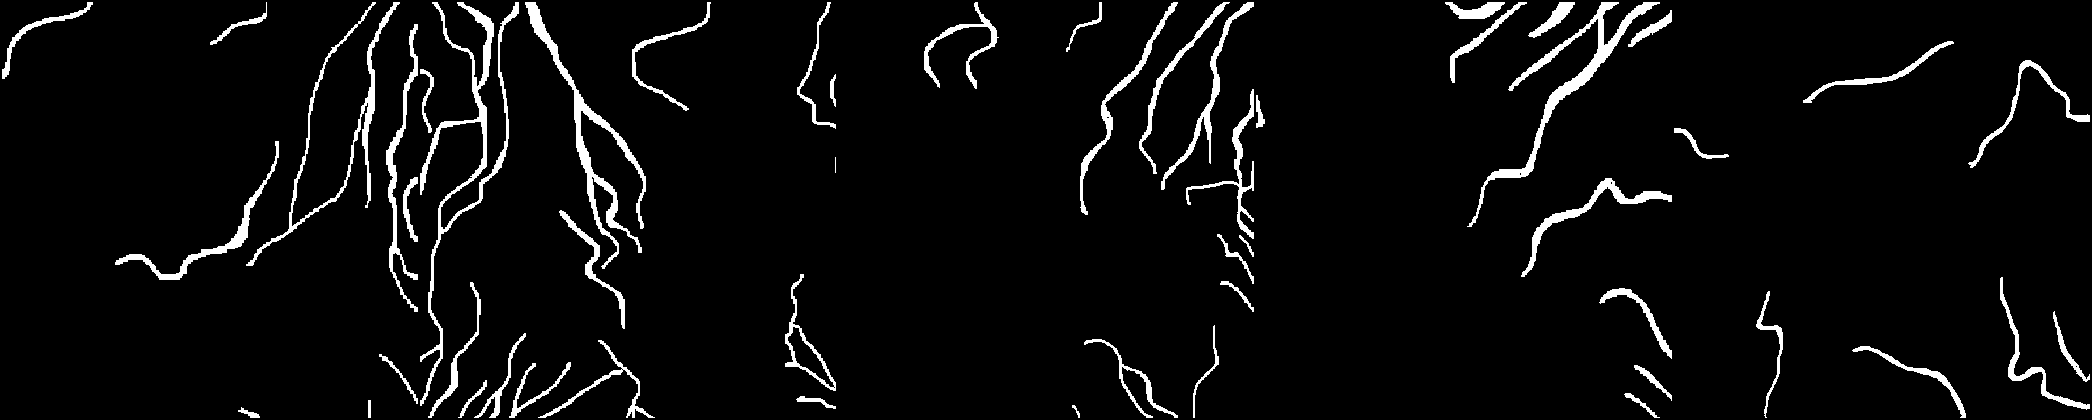

In [15]:
TF.to_pil_image(torchvision.utils.make_grid(mask_r[:5].unsqueeze(-3).expand(5, 3, 416, 416).type(torch.float)))

In [16]:
from sklearn.metrics import jaccard_score, precision_score, recall_score
def calc_metric(labels, preds):
    accuracy = np.mean(np.equal(labels,preds))
    right = np.sum(labels *preds == 1)
    precision = right / np.sum(preds)
    recall = right / np.sum(labels)
    f1 = 2 * precision*recall/(precision+recall)

    
    y_pred = preds
    y_true = labels
    """ Ground truth """
    #y_true = y_true.cpu().numpy()
    y_true = y_true > 0.5
    y_true = y_true.astype(np.uint8)
    y_true = y_true.reshape(-1)

    """ Prediction """
    #y_pred = y_pred.cpu().numpy()
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.uint8)
    y_pred = y_pred.reshape(-1)

    score_jaccard = jaccard_score(y_true, y_pred)

    print('jaccard, f1, recall, precision, acc')
    print(score_jaccard, f1, recall, precision, accuracy)
    return score_jaccard, f1, recall, precision, accuracy

# Train

In [ ]:
from typing import DefaultDict
from sklearn.exceptions import DataDimensionalityWarning
from tensorboardX import SummaryWriter
import datetime 

exp = 'PFNet_2class+aug+coslr'

num_epochs = args['epoch_num']
resume_epochs = args['last_epoch']
load_from = '../model/vessel_PFNet_base_b32_e500_220921_00:30.pt'


batch_size = args['train_batch_size']
scaler = torch.cuda.amp.GradScaler()
now = datetime.datetime.now()
log_name = f'{exp}_b{batch_size}_e{num_epochs}_js_'+now.strftime("%y%m%d_%H:%M")
writer = SummaryWriter(log_dir='./ckpt/PFNet/log/'+ log_name)
save_path = f'../model/vessel_{exp}_b{batch_size}_e{num_epochs}_'+ now.strftime("%y%m%d_%H:%M") + '.pt'
save_path2 = f'../model/vessel_{exp}_y_b{batch_size}_e{num_epochs}_'+ now.strftime("%y%m%d_%H:%M") + '.pt'
if torch.cuda.device_count() > 1:
    print(f'Using {torch.cuda.device_count()} GPUs.')
    
net_r = nn.DataParallel(net_r)
net_y = nn.DataParallel(net_y)

# net.float()
net_r = net_r.to(device)
net_y = net_y.to(device)

test_acc_list = []
test_recall_list = []
test_f1_list = []
test_miou_list = []
print(log_name)
print(save_path)
print(f'Training {num_epochs} epochs.')
# if resume_epochs != 0:
#     print(f'Resuming from epoch {resume_epochs}')
#     net.load_state_dict(torch.load(load_from))

# print(data.shape, aug_masks[0].shape, aug_masks[1].shape, aft_mask.shape)
curr_iter = 1

for epoch in range(args['last_epoch'], args['last_epoch'] + args['epoch_num']):
    
    net_r.train()
    net_y.train()

    loss_r_running, loss_y_running=0, 0
    tqdm_dataset = tqdm(train_loader)
    for batch_idx, batch in enumerate(tqdm_dataset):

        # label: ([32, 2, 416, 416])
        image, [mask_r, mask_y], _= batch   # mask : 32, 416, 416
        image = image.float().to(device)
        mask_r = mask_r.unsqueeze(1).long().to(device)
        mask_y = mask_y.unsqueeze(1).long().to(device)

        optimizer_r.zero_grad()
        optimizer_y.zero_grad()

        pred_r = net_r(image)
        pred_y = net_y(image)

        loss_r = dice_loss(pred_r, mask_r)
        loss_y = dice_loss(pred_y, mask_y)


        # loss = loss_r + 0.5 * loss_y
        # loss = loss_r + 0.2*loss_y
        # loss = loss_r
        
        loss_r.backward()
        loss_y.backward()
        # nn.utils.clip_grad_norm_(net.parameters(), max_norm=10)
        optimizer_r.step()
        optimizer_y.step()
        
        loss_r_running += loss_r.item()
        loss_y_running += loss_y.item()
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch,
            'Loss_r': '{:06f}'.format(loss_r.item()),
            'Mean Loss_r' : '{:06f}'.format(loss_r_running/(batch_idx+1)),
            'Loss_y': '{:06f}'.format(loss_y.item()),
            'Mean Loss_y' : '{:06f}'.format(loss_y_running/(batch_idx+1)),
            'lr' : '{:06f}'.format(optimizer_r.param_groups[0]["lr"]),
        })

        curr_iter += 1

    epoch_loss_r = loss_r_running / len(train_loader)
    epoch_loss_y = loss_y_running / len(train_loader)

    writer.add_scalar('loss_R/Train', epoch_loss_r, epoch)
    writer.add_scalar('loss_Y/Train', epoch_loss_y, epoch)
    writer.add_scalar('learning_rate', optimizer_r.param_groups[0]["lr"], epoch)
    scheduler_r.step()
    scheduler_y.step()

## EVAL
    if epoch % 5 == 0 or epoch == args['epoch_num']-1 :
        print("Testing...")

        images=[]
        pred_rs=[]
        pred_ys=[]
        mask_rs=[]
        mask_ys=[]
        mask_os = []
        
        net_r.eval()
        net_y.eval()
        # tqdm_loader = tqdm(test_loader)
        with torch.no_grad():
            loss_r_running, loss_y_running=0, 0
            for idx, batch in enumerate(tqdm(test_loader)):

                image, [mask_r, mask_y], _= batch   # mask : 32, 416, 416
                image = image.float().to(device)
                mask_r = mask_r.unsqueeze(1).long().to(device)
                mask_y = mask_y.unsqueeze(1).long().to(device)

                pred_r = net_r(image)
                pred_y = net_y(image)

                loss_r = dice_loss(pred_r, mask_r)
                loss_y = dice_loss(pred_y, mask_y)
                # loss_r = dice_loss(pred[:, 0], mask[:, 0])
                # loss_y = dice_loss(pred[:, 1], mask[:, 1])

                # loss = loss_r + 0.5 * loss_y
                loss_r_running += loss_r.item()
                loss_y_running += loss_y.item()

                images.append(image.cpu().detach().numpy()) # ((355, 1, 3, 416, 416), (355, 1, 2, 416, 416), (355, 1, 2, 416, 416))
                
                mask_rs.append(mask_r.cpu().detach().numpy())   # B, 3, 416, 416
                mask_ys.append(mask_y.cpu().detach().numpy())
                
                pred_rs.append(pred_r.cpu().detach().numpy())
                pred_ys.append(pred_y.cpu().detach().numpy())
                mask_os.append(mask_o)
                
            images= np.array(images).squeeze(1)
            mask_rs = np.array(mask_rs).squeeze(1)
            mask_ys = np.array(mask_ys).squeeze(1)
            pred_rs = np.array(pred_rs).squeeze(1)
            pred_ys = np.array(pred_ys).squeeze(1)
            mask_os = np.array(mask_os)

            pred_rs = np.where(pred_rs > 0.5 , 1, 0)
            pred_ys = np.where(pred_ys > 0.5 , 1, 0)

            mask_rs = np.where(mask_rs > 0.5, 1, 0)
            mask_ys = np.where(mask_ys > 0.5, 1, 0)
            preds = np.clip(pred_rs-pred_ys, 0, 1)

            epoch_loss_r = loss_r_running / len(test_loader)
            epoch_loss_y = loss_y_running / len(test_loader)
            print(f"Test loss R, Y: {epoch_loss_r}, {epoch_loss_y}")

            # 빨간색 라벨만 계산
            score_jaccard, score_f1, score_recall, score_precision, score_acc = calc_metric(labels=mask_rs, preds=preds)
            
            test_acc_list.append(score_acc)
            test_recall_list.append(score_recall)
            test_f1_list.append(score_f1)
            test_miou_list.append(score_jaccard)

            writer.add_scalar('loss_R/Test', epoch_loss_r, epoch)
            writer.add_scalar('loss_Y/Test', epoch_loss_y, epoch)
            writer.add_scalar('Accuracy/Test', score_acc, epoch)
            writer.add_scalar('F1/Test', score_f1, epoch)
            writer.add_scalar('Recall/Test', score_recall, epoch)
            writer.add_scalar('Precision/Test', score_precision, epoch)
            writer.add_scalar('Jaccard/Test', score_jaccard, epoch)

            if np.max(test_miou_list) == test_miou_list[-1]:
                torch.save(net_r.state_dict(), save_path)
                torch.save(net_y.state_dict(),save_path2)
                print("Model Saved")

            randnum = np.random.randint(0, 355)

            # 시각화
            plt.figure(figsize=(16, 5))
            plt.subplot(1, 6, 1)  
            plt.imshow(mask_os[randnum][0].permute(1, 2, 0))
            plt.axis('off')
            plt.subplot(1, 6, 2)  
            plt.imshow(mask_rs[randnum][0]) # TypeError: Invalid shape (1, 416, 416)
            plt.axis('off')
            plt.subplot(1, 6, 3)
            plt.imshow(pred_rs[randnum][0])
            plt.axis('off')
            plt.subplot(1, 6, 4)
            plt.imshow(mask_ys[randnum][0])
            plt.axis('off')
            plt.subplot(1, 6, 5)
            plt.imshow(pred_ys[randnum][0])
            plt.axis('off')
            plt.subplot(1, 6, 6)
            plt.imshow(preds[randnum][0])
            plt.axis('off')
            plt.tight_layout()
            plt.show()

In [ ]:
# preds = preds.squeeze(1)

In [ ]:
np.array(preds).shape

In [ ]:
net(image.float()).shape

In [ ]:
net(image.float()).shape

In [ ]:
image, [mask_r, mask_y], mask_o = next(iter(test_loader))

In [ ]:
mask_r.shape

In [ ]:
mask_o.shape

In [ ]:
image.shape

In [ ]:
image.shape

In [ ]:
images.shape

In [ ]:
plt.imshow(np.array(preds).squeeze(2)[0][2])

# evaluation

In [ ]:
print("Testing...")
net = SA_UNet(in_channels=3, num_classes=2 , base_c=16)
load_from = '/home/sklab2/workspace/code_only/junsu/model/vessel_SA-UNet_2lb_base_b32_e300_221002_12:16.pt'
if torch.cuda.device_count() > 1:
    print(f'Using {torch.cuda.device_count()} GPUs.')
net = nn.DataParallel(net)
net.load_state_dict(torch.load(save_path))
net.to(device)

images=[]
preds=[]
labels=[]
label_os = []
net.eval()
# tqdm_loader = tqdm(test_loader)
with torch.no_grad():
    loss_running = 0
    for idx, batch in enumerate(tqdm(test_loader)):

        image, mask, mask_o= batch
        image = image.float().to(device)
        mask = mask.long().to(device)
        pred = net(image)
        
        loss = dice_loss(pred, mask)
        # loss_r = dice_loss(pred[:, 0], mask[:, 0])
        # loss_y = dice_loss(pred[:, 1], mask[:, 1])

        # loss = loss_r + 0.5 * loss_y
        loss_running += loss.item()

        images.append(image.cpu().detach().numpy())
        masks.append(mask.cpu().detach().numpy())   # B, 3, 416, 416
        preds.append(pred.cpu().detach().numpy())
        mask_os.append(mask_o)

    images= np.array(images)#.squeeze(1)
    # preds = np.expand_dims(np.array(preds)[:, 0], axis=1)
    masks = np.array(masks).squeeze(1)
    preds = np.array(preds).squeeze(1)
    
    preds = np.where(preds > 0.5 , 1 , 0)
    masks = np.where(masks > 0.5, 1, 0)
    mask_os = np.array(mask_os)
    epoch_loss = loss_running / len(test_loader)
    print(f"Test loss: {epoch_loss}")

    assert preds.shape == masks.shape
    # 빨간색 라벨만 계산
    score_jaccard, score_f1, score_recall, score_precision, score_acc = calc_metric(labels=masks[:, 0], preds=preds[:, 0])

In [ ]:
# randnum = np.random.randint(0, len(test_dataset)-10)
randnum=211

fig, axes = plt.subplots(10, 3, figsize = (10,40))
[c_ax.axis('off') for c_ax in axes.flatten()]

for idx, (img_ax, target_ax , mask_ax ) in zip(range(randnum, randnum+10), axes):
    
# inputs[:10] , preds[:10], targets[:10], urls_list[:10]) :
    
    image = images[idx].astype(int).transpose(1, 2, 0) # astype(int)
    img_target = preds[idx].transpose(1, 2, 0) 
    img_mask = labels[idx].transpose(1, 2, 0)  
 
    img_ax.imshow(np.clip(image, 0, 255))

    target_ax.imshow(img_target )
    mask_ax.imshow(img_mask)

    img_ax.set_title(f'  testing: {idx}')
    target_ax.set_title(f' Predicted : {idx}')
    
    mask_ax.set_title(f' target   vessel: {idx}')
plt.tight_layout()
plt.show()
 